- Reference<br>
Medium - Multi-label Text Classification with BERT using Pytorch<br>
https://kyawkhaung.medium.com/multi-label-text-classification-with-bert-using-pytorch-47011a7313b9<br>
Kaggle - Multi Label Image Classification<br>
https://www.kaggle.com/code/boascent/multi-label-image-classification-pytorch-gpu/notebook<br>

- Import Module

In [1]:
# torch/BERT
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertModel, BertTokenizer

# evaluation matrix
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

# basic package
from sklearn.model_selection import train_test_split
import numpy as np, pandas as pd, random
import matplotlib.pyplot as plt
import seaborn as sn
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

# check CUDA(GPU)
print('Is CUDA available ?',torch.cuda.is_available())
device = torch.device('cuda:0')

# reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

Is CUDA available ? True


- Dataset

In [2]:
# read review datasets 
def READ(game_name):
    temp = pd.read_excel(f'data_cleaned\\labeled data\\{game_name}.xlsx')[:1000]
    temp['game'] = game_name
    return temp

# combine datasets
game_list = ['Warhammer 40,000 - Darktide','Brotato','Cult of the Lamb','Teardown','Mount & Blade 2 - Bannerlord']
df_train = pd.concat([READ(game) for game in game_list])
df_train = df_train[df_train.Spam == 0] # drop spam review
df_train.drop(columns = ['Spam', 'date', 'helpful_votes', 'check'], inplace = True) # drop unneccessary column
df_train.dropna(inplace = True)

# sampe 
def SAMPLE(i, num = 140, df = df_train, seed = SEED):
    tag_list = ['Not helpful','Suggestion','Pro','Con','Bug']
    return df[df[tag_list[i]]==1].sample(n = num, random_state = seed)
df_train = pd.concat([df_train[df_train['Not helpful']!=1], SAMPLE(0, num = 250)])
print(df_train.shape)

# split to training and testing
train_dataset, test_dataset = train_test_split(df_train, test_size = 0.3, random_state = SEED)

(2055, 7)


- Model

In [3]:
# tokenization(return token_id and attention_mask)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case = True)
def tokenization(sentences):
    input_ids, attention_masks = [], []
    for text in sentences:        
        encoded_dict = tokenizer.encode_plus(text,add_special_tokens = True,
                                             max_length = 150, pad_to_max_length = True,
                                             return_attention_mask = True, return_tensors = 'pt')  
        input_ids.append(encoded_dict['input_ids'])     
        attention_masks.append(encoded_dict['attention_mask'])
    return torch.cat(input_ids, dim = 0).to(device), torch.cat(attention_masks, dim = 0).to(device)

In [4]:
# hyperparameters
num_epochs = 5
batch_size = 10
learning_rate = 0.0001
Labels_list = ['Not helpful','Suggestion','Pro','Con','Bug']
num_class = len(Labels_list)

# neural network
class BertClassifier(nn.Module):
    def __init__(self, num_class):
        super(BertClassifier, self).__init__()
        # bert embedding
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        # linear layer(uses pooled output a.k.a [CLS] as input)
        self.linear1 = nn.Linear(self.bert.config.hidden_size, 64)
        # linear layer
        self.linear2 = nn.Linear(64, num_class)
        self.elu = nn.ELU(inplace = True)
        
    def forward(self, ids, mask):
        output = self.bert(input_ids = ids, attention_mask = mask)
        output = self.linear1(output[1])
        return self.linear2(output)

- Model training

In [6]:
# dataloader
Input_ids, Attention_Masks = tokenization(train_dataset.review_clear.values)
Labels = torch.tensor(train_dataset[Labels_list].astype(float).values).to(device)
train_loader = DataLoader(dataset = TensorDataset(Input_ids, Attention_Masks, Labels), batch_size  = batch_size, shuffle = True)

# model(# train only the linear layer)
bert = BertClassifier(num_class).to(device)
for param in bert.bert.parameters(): 
    param.requires_grad = True

# loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(bert.parameters(), lr = learning_rate)

# model training
bert.train()
total_steps, loss_list = len(train_loader), []
# epoch loop
for epoch in range(num_epochs):
    clear_output(wait = True)
    epoch_loss = 0

    # batch iteration
    for step, batch in enumerate(train_loader):
        print(f'Epoch [{epoch+1}/{num_epochs}] Iteration [{step}/{total_steps}]')
        clear_output(wait = True)
        
        # forward pass
        ids, mask, labels = batch
        output = bert(ids, mask)
        loss = criterion(output, labels)
        
        # record loss and accuaracy
        epoch_loss += loss
        
        #release memory
        del ids, mask, labels
        torch.cuda.empty_cache()
        
        # backward and optimize
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
       
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/(step+1)}')
    loss_list.append(epoch_loss/(step+1))

The smallest loss: 0.19702668836411572


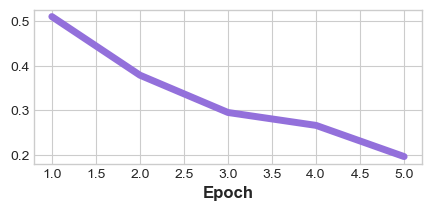

In [10]:
print(f'The smallest loss: {min(loss_list)}')
fig = plt.figure()
plt.style.use('seaborn-whitegrid') 
plt.plot(range(1,len(loss_list)+1),[float(x.cpu().detach()) for x in loss_list],c = "mediumpurple",linewidth = 5.0) 
plt.xlabel("Epoch", fontweight = "bold",fontsize = 12)                        
fig.set_size_inches(5, 2) 
plt.show()

- Inference

In [11]:
# dataloader
Input_ids, Attention_Masks = tokenization(test_dataset.review_clear.values)
test_loader = DataLoader(dataset = TensorDataset(Input_ids, Attention_Masks), batch_size  = batch_size)

# evaluation
bert.eval()
test_predict_list= []
with torch.no_grad():
    for step, batch in enumerate(test_loader):
        ids, mask = batch
        test_predict_list += torch.sigmoid(bert(ids, mask)).cpu().detach().numpy().tolist()

# the validation dataset
df_valid = test_dataset[['game']+Labels_list]
display(df_valid.groupby(['game']).sum())

# confusion matrix
pred = (np.array(test_predict_list) > 0.5).astype(float)
actu = test_dataset[Labels_list].astype(float).values

# label numbers in testing data / precision / accuaracy
for i in range(len(Labels_list)):
    print(Labels_list[i])
    numbers = 0
    accuracy_num = 0
    predict_num = 0
    predict_right_num = 0
    for y, y_hat in zip(actu[:,i], pred[:,i]):
        if y==1:
            numbers += 1
        if y_hat==1:
            predict_num += 1 
        if y_hat==1 and y==1:
            predict_right_num += 1 
        if y_hat==y:
            accuracy_num += 1
    print('total label nums:', numbers,'/',len(actu[:,i]))
    if predict_num==0:
        print('precision: no predict')
    else:
        print('precision:', predict_right_num/predict_num)
    print('accuracy:', accuracy_num/len(actu[:,i]))
    print('---'*15)

,Not Helpful,Suggestion,Pro,Con(Non-Bug),Con(Crash),Con(Non-Crash)
game,,,,,,
Baldur's Gate 3,12,0,5,2,1,2
Battlefields 2042,17,0,3,8,4,8
Dying Light 2 Stay Human,12,0,11,6,3,4
God of War,28,1,7,0,0,0
Monster Hunter Stories 2: 破滅之翼,14,1,7,5,0,1
NARAKA: BLADEPOINT,20,0,3,7,0,2
Pathfinder: Wrath of the Righteous - Enhanced Edition,15,0,7,5,1,4
Road 96,19,1,15,3,0,0


Not Helpful
total label nums: 137 / 239
precision: 0.9210526315789473
accuracy: 0.8284518828451883
---------------------------------------------
Suggestion
total label nums: 3 / 239
precision: no predict
accuracy: 0.9874476987447699
---------------------------------------------
Pro
total label nums: 58 / 239
precision: 0.7540983606557377
accuracy: 0.8870292887029289
---------------------------------------------
Con(Non-Bug)
total label nums: 36 / 239
precision: 0.4423076923076923
accuracy: 0.8242677824267782
---------------------------------------------
Con(Crash)
total label nums: 9 / 239
precision: no predict
accuracy: 0.9623430962343096
---------------------------------------------
Con(Non-Crash)
total label nums: 21 / 239
precision: no predict
accuracy: 0.9121338912133892
---------------------------------------------
